### Notebook for the integration and label transfer of CD45+ lymphoid immune cells with `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius-Maximilian-Universität Würzburg**
- v231212

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
absl                NA
aiohttp             3.8.5
aiosignal           1.3.1
annotated_types     0.5.0
anyio               NA
asttokens           NA
async_timeout       4.0.3
attr                23.1.0
backcall            0.2.0
backoff             2.2.1
bs4                 4.12.2
certifi             2023.07.22
charset_normalizer  3.2.0
chex                0.1.7
click               8.1.7
comm                0.1.4
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
deepdiff            6.3.1
docrep              0.3.2
etils               1.4.1
executing           1.2.0
fastapi             0.103.0
flax                0.7.2
frozenlist          1.4.0
fsspec              2023.6.0
h5py                3.9.0
idna                3.4
igraph              0.10.8
importlib_resources NA
ipykernel         

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in and format individual cell compartments

- Read in CD45+ immune cells 

In [5]:
MDX_MPC = sc.read_h5ad('../../data/MDX_MPC.h5ad')
MDX_MPC.obs['genotype'] = MDX_MPC.obs['Condition'].copy()
MDX_MPC.obs['sample'] = MDX_MPC.obs['hash.ID'].copy()
MDX_MPC.obs['donor'] = MDX_MPC.obs['Sample'].copy()
MDX_MPC.obs['seed_labels'] = MDX_MPC.obs['MPC_Annotation'].copy()
MDX_MPC.obs['cell_source'] = 'HIRI-CD45+'
MDX_MPC

AnnData object with n_obs × n_vars = 6305 × 31053
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'MPC_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [6]:
MDX_POOL_NEW = sc.read_h5ad('../../data/MDX_POOL_NEW.h5ad')
MDX_POOL_NEW.obs['genotype'] = MDX_POOL_NEW.obs['Condition'].copy()
MDX_POOL_NEW.obs['sample'] = MDX_POOL_NEW.obs['hash.ID'].copy()
MDX_POOL_NEW.obs['donor'] = MDX_POOL_NEW.obs['Sample'].copy()
MDX_POOL_NEW.obs['seed_labels'] = MDX_POOL_NEW.obs['CD45_Annotation'].copy()
MDX_POOL_NEW.obs['cell_source'] = 'HIRI-CD45+'
MDX_POOL_NEW

AnnData object with n_obs × n_vars = 11098 × 31053
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

- Read in Lymphoid cells

In [7]:
Lymphoid_scANVI = sc.read_h5ad('../../data/heart_mm_nuclei-23-0092_scANVI-Lymphoid_ctl231128.raw.h5ad')
Lymphoid_scANVI.obs_names = [name.rsplit('-', 2)[0] for name in Lymphoid_scANVI.obs_names]
Lymphoid_scANVI.obs['seed_labels'] = Lymphoid_scANVI.obs['C_scANVI'].copy()
Lymphoid_scANVI

AnnData object with n_obs × n_vars = 451 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Merge cell compartments and compare with full object

In [8]:
compartments = MDX_POOL_NEW.concatenate(Lymphoid_scANVI, MDX_MPC, 
                                      batch_key = 'compartment', 
                                      batch_categories = ['MDX_POOL_NEW', 'Lymphoid_scANVI', 'MDX_MPC'], 
                                      join = 'inner')
compartments.obs_names = [name.rsplit('-', 1)[0] for name in compartments.obs_names]
compartments

AnnData object with n_obs × n_vars = 17854 × 27478
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'cell_states', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-Lymphoid_scANVI', 'feature_types-Lymphoid_scANVI', 'genome-Lymphoid_scANVI', 'mt-Lymphoid_scANVI', 'ribo-Lymphoid_scANVI', 'n_cells_by_counts-Lym

### Group fine grained annotations into coarse groups

In [9]:
compartments.obs['seed_labels'].cat.categories

Index(['A_Res_Mac_MHCII', 'B', 'B_Cells', 'B_TLF_Mac', 'B_plasma', 'CD4+T_act',
       'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans',
       'C_Ccr2+MHCII+_Mac', 'Conventional_T', 'D_Inflammatory_Mac', 'E_Isg15+',
       'F_Spp1+Gpnmb+', 'G_Ly6Chi_Mo', 'H_Ly6Clow_Mo', 'ILC2', 'I_cDC2',
       'J_Mature_DC', 'K_nd1', 'L_nd2', 'Ly6Chi_Mono', 'Ly6Clo_Mono',
       'M_low_quality', 'Macrophages', 'Mast/Baso', 'NK', 'NK_CD16hi',
       'NK_CD56hi', 'Neutrophils', 'Proliferating', 'cDC2', 'gd_T',
       'low_quality_cells', 'myeloid??', 'non-immune', 'pDC'],
      dtype='object')

- Remove low quality or lymphoid cells

In [10]:
compartments_clean = compartments[~compartments.obs['seed_labels'].isin(['A_Res_Mac_MHCII', 'B_TLF_Mac',
       'C_Ccr2+MHCII+_Mac', 'D_Inflammatory_Mac', 'G_Ly6Chi_Mo', 'H_Ly6Clow_Mo', 'I_cDC2', 'J_Mature_DC', 
       'K_nd1', 'L_nd2', 'Ly6Chi_Mono', 'Ly6Clo_Mono', 'M_low_quality', 'Macrophages', 'Mast/Baso', 'Neutrophils', 
       'Proliferating', 'gd_T', 'low_quality_cells', 'myeloid??', 'pDC', 'cDC2'])]
compartments_clean

View of AnnData object with n_obs × n_vars = 3184 × 27478
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'cell_states', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-Lymphoid_scANVI', 'feature_types-Lymphoid_scANVI', 'genome-Lymphoid_scANVI', 'mt-Lymphoid_scANVI', 'ribo-Lymphoid_scANVI', 'n_cells_by_cou

### Make uniform annotation for genotype labels

In [11]:
compartments_clean.obs['genotype'].value_counts()

genotype
Mdx         1177
Mdx-SCID     941
Ctrl         809
MdxSCID      210
WT            47
Name: count, dtype: int64

In [12]:
trans_from=[['MdxSCID', 'Mdx-SCID'],
['Ctrl', 'WT']]
trans_to = ['MdxSCID', 'WT']

compartments_clean.obs['genotype'] = [str(i) for i in compartments_clean.obs['genotype']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        compartments_clean.obs['genotype'][compartments_clean.obs['genotype'] == leiden_from] = celltype

In [13]:
compartments_clean.obs['genotype'].value_counts()

genotype
Mdx        1177
MdxSCID    1151
WT          856
Name: count, dtype: int64

In [14]:
del(compartments_clean.obs['C_scANVI'])
compartments_clean

AnnData object with n_obs × n_vars = 3184 × 27478
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'cell_states', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'leiden', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-Lymphoid_scANVI', 'feature_types-Lymphoid_scANVI', 'genome-Lymphoid_scANVI', 'mt-Lymphoid_scANVI', 'ribo-Lymphoid_scANVI', 'n_cells_by_counts-Lymphoid_scANVI'

### Visualise cell type distribution per condition

In [15]:
compartments_clean.obs['seed_labels'].value_counts()

seed_labels
NK                1179
B_Cells            987
Conventional_T     188
E_Isg15+           170
NK_CD16hi          160
CD4+T_naive        123
ILC2               103
F_Spp1+Gpnmb+       78
NK_CD56hi           36
CD8+T_trans         31
non-immune          28
B_plasma            25
CD8+T_te            19
B                   17
CD8+T_em            16
CD4+T_act           14
CD8+T_cytox         10
Name: count, dtype: int64

### Hamonise cell type labels

In [16]:
compartments_clean.obs['seed_labels'].cat.categories

Index(['B', 'B_Cells', 'B_plasma', 'CD4+T_act', 'CD4+T_naive', 'CD8+T_cytox',
       'CD8+T_em', 'CD8+T_te', 'CD8+T_trans', 'Conventional_T', 'E_Isg15+',
       'F_Spp1+Gpnmb+', 'ILC2', 'NK', 'NK_CD16hi', 'NK_CD56hi', 'non-immune'],
      dtype='object')

In [17]:
trans_from = [['Conventional_T', 'non-immune']]
trans_to = ['Unknown']

compartments_clean.obs['seed_labels'] = [str(i) for i in compartments_clean.obs['seed_labels']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        compartments_clean.obs['seed_labels'][compartments_clean.obs['seed_labels'] == leiden_from] = celltype

- The label 'Macrophages' is very unspecific and takes a lot of cells. To allow for other detailed annotations to be mapped, I will label them as 'Unknown'

In [18]:
compartments_clean.obs['seed_labels'] = compartments_clean.obs['seed_labels'].astype('category')
compartments_clean.obs['seed_labels'].cat.categories

Index(['B', 'B_Cells', 'B_plasma', 'CD4+T_act', 'CD4+T_naive', 'CD8+T_cytox',
       'CD8+T_em', 'CD8+T_te', 'CD8+T_trans', 'E_Isg15+', 'F_Spp1+Gpnmb+',
       'ILC2', 'NK', 'NK_CD16hi', 'NK_CD56hi', 'Unknown'],
      dtype='object')

In [19]:
pd.crosstab(compartments_clean.obs['seed_labels'], compartments_clean.obs['genotype'])

genotype,Mdx,MdxSCID,WT
seed_labels,,,
B,5,7,5
B_Cells,515,0,472
B_plasma,6,11,8
CD4+T_act,4,5,5
CD4+T_naive,83,27,13
CD8+T_cytox,7,3,0
CD8+T_em,5,11,0
CD8+T_te,5,12,2
CD8+T_trans,10,19,2


### Read in other unannotated dataset and split into groups

In [20]:
compartments_clean.obs['genotype'].value_counts()

genotype
Mdx        1177
MdxSCID    1151
WT          856
Name: count, dtype: int64

In [21]:
reference = compartments_clean[compartments_clean.obs['genotype'].isin(['MdxSCID', 'WT'])]
reference

View of AnnData object with n_obs × n_vars = 2007 × 27478
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'cell_states', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'leiden', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-Lymphoid_scANVI', 'feature_types-Lymphoid_scANVI', 'genome-Lymphoid_scANVI', 'mt-Lymphoid_scANVI', 'ribo-Lymphoid_scANVI', 'n_cells_by_counts-Lymphoid

In [22]:
query = compartments_clean[~compartments_clean.obs['genotype'].isin(['MdxSCID', 'WT'])]
query.obs['seed_labels'] = 'Unknown'
query

AnnData object with n_obs × n_vars = 1177 × 27478
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'cell_states', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'leiden', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-Lymphoid_scANVI', 'feature_types-Lymphoid_scANVI', 'genome-Lymphoid_scANVI', 'mt-Lymphoid_scANVI', 'ribo-Lymphoid_scANVI', 'n_cells_by_counts-Lymphoid_scANVI'

In [23]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 3184 × 27478
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'cell_states', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'leiden', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-Lymphoid_scANVI', 'feature_types-Lymphoid_scANVI', 'genome-Lymphoid_scANVI', 'mt-Lymphoid_scANVI', 'ribo-Lymphoid_scANVI', 'n_cells_by_counts-Lymphoid_scANVI'

- Clean merged object

In [24]:
del(adata.obs['Condition'])
del(adata.obs['hash.ID'])
del(adata.obs['Sample'])
del(adata.obs['HTO_maxID'])
del(adata.obs['HTO_secondID'])
del(adata.obs['HTO_margin'])
del(adata.obs['nCount_RNA'])
del(adata.obs['nFeature_RNA'])
del(adata.obs['nCount_ADT'])
del(adata.obs['nFeature_ADT'])
del(adata.obs['percent.mt'])
del(adata.obs['RNA_snn_res.0.2'])
del(adata.obs['seurat_clusters'])
del(adata.obs['RNA_snn_res.0.3'])
del(adata.obs['RNA_snn_res.0.5'])
adata

AnnData object with n_obs × n_vars = 3184 × 27478
    obs: 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'cell_states', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'leiden', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-Lymphoid_scANVI', 'feature_types-Lymphoid_scANVI', 'genome-Lymphoid_scANVI', 'mt-Lymphoid_scANVI', 'ribo-Lymphoid_scANVI', 'n_cells_by_counts-Lymphoid_scANVI', 'mean_counts-Lymphoid_scANVI', 'pct_dropout_by_counts-Lymphoid_scANVI', 'total_counts-Lymphoid_scANVI', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.va

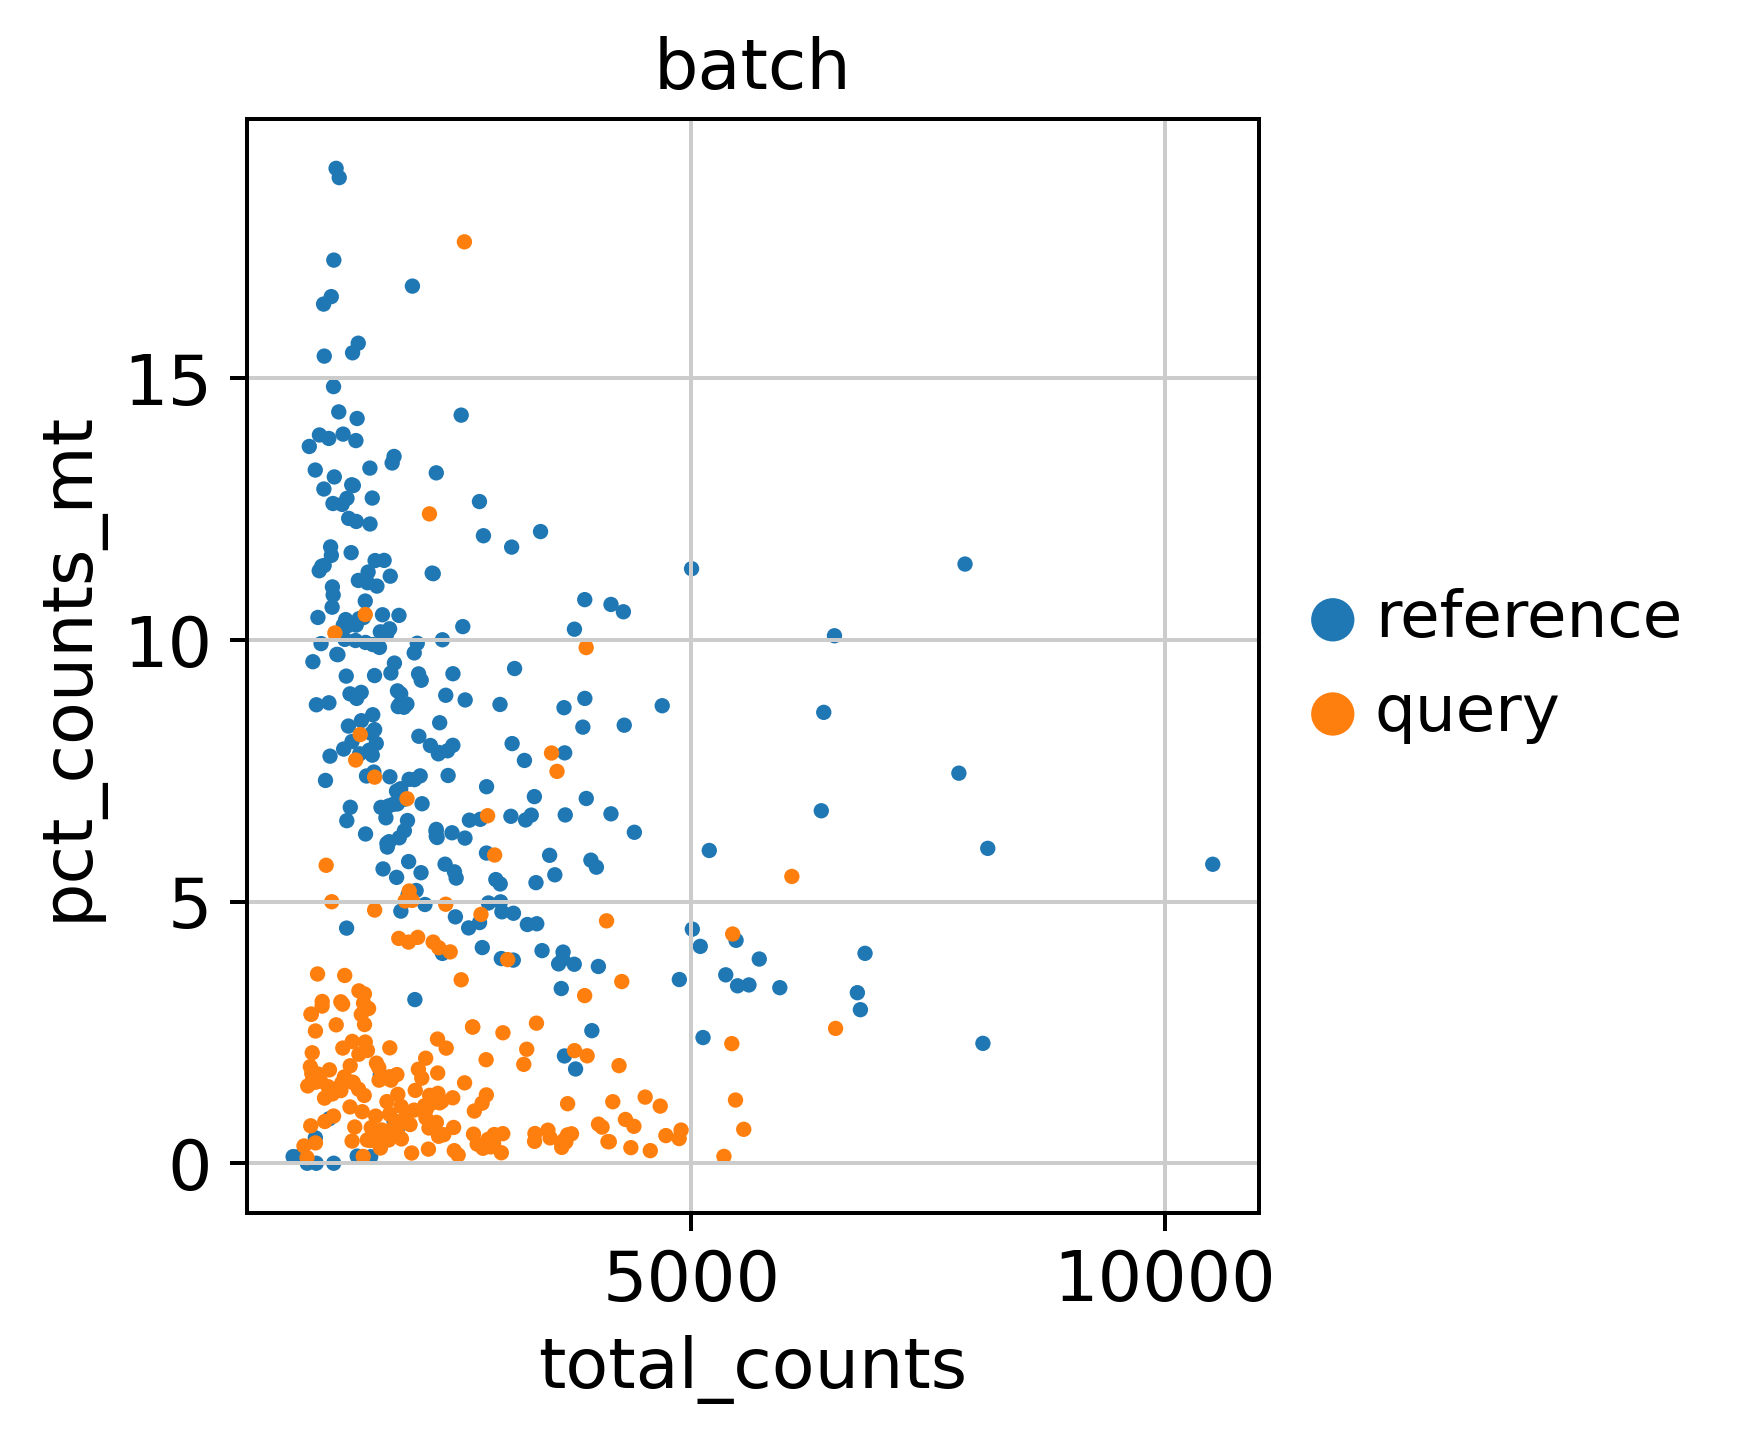

In [25]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt', color = "batch", frameon = False)

In [26]:
adata.obs['genotype'].value_counts()

genotype
Mdx        1177
MdxSCID    1151
WT          856
Name: count, dtype: int64

In [27]:
adata.obs['sample'].value_counts()

sample
Hashtag7-TotalA     295
Hashtag4-TotalA     289
Hashtag1-TotalA     277
Hashtag15-TotalA    240
Hashtag9-TotalA     218
Hashtag8-TotalA     203
Hashtag2-TotalA     202
Hashtag6-TotalA     187
Hashtag12-TotalA    178
Hashtag11-TotalA    171
B1_2                145
Hashtag13-TotalA    137
Hashtag5-TotalA     114
A12_2                97
A11_2                97
Hashtag14-TotalA     83
Hashtag10-TotalA     80
B2_2                 65
Hashtag3-TotalA      59
A10_2                32
A9_2                 15
Name: count, dtype: int64

### Select HVGs

In [28]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 3184 × 7000
    obs: 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'cell_states', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'leiden', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-Lymphoid_scANVI', 'feature_types-Lymphoid_scANVI', 'genome-Lymphoid_scANVI', 'mt-Lymphoid_scANVI', 'ribo-Lymphoid_scANVI', 'n_cells_by_counts-Lymphoid_scANVI', 'mean_counts-Lymphoid_scANVI', 'pct_dropout_by_counts-Lymphoid_scANVI', 'total_counts-Lymphoid_scANVI', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.var

### Transfer of annotation with scANVI

In [29]:
scvi.model.SCVI.setup_anndata(adata,
                              batch_key = "sample", 
                            categorical_covariate_keys = ["donor", "cell_source"], 
                            labels_key = "seed_labels", 
                            layer = 'counts')

In [30]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [31]:
scvi_model.train(20, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 use_gpu = 0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 20/20: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s, v_num=1, train_loss_step=3.14e+3, train_loss_epoch=3.04e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, v_num=1, train_loss_step=3.14e+3, train_loss_epoch=3.04e+3]


In [32]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

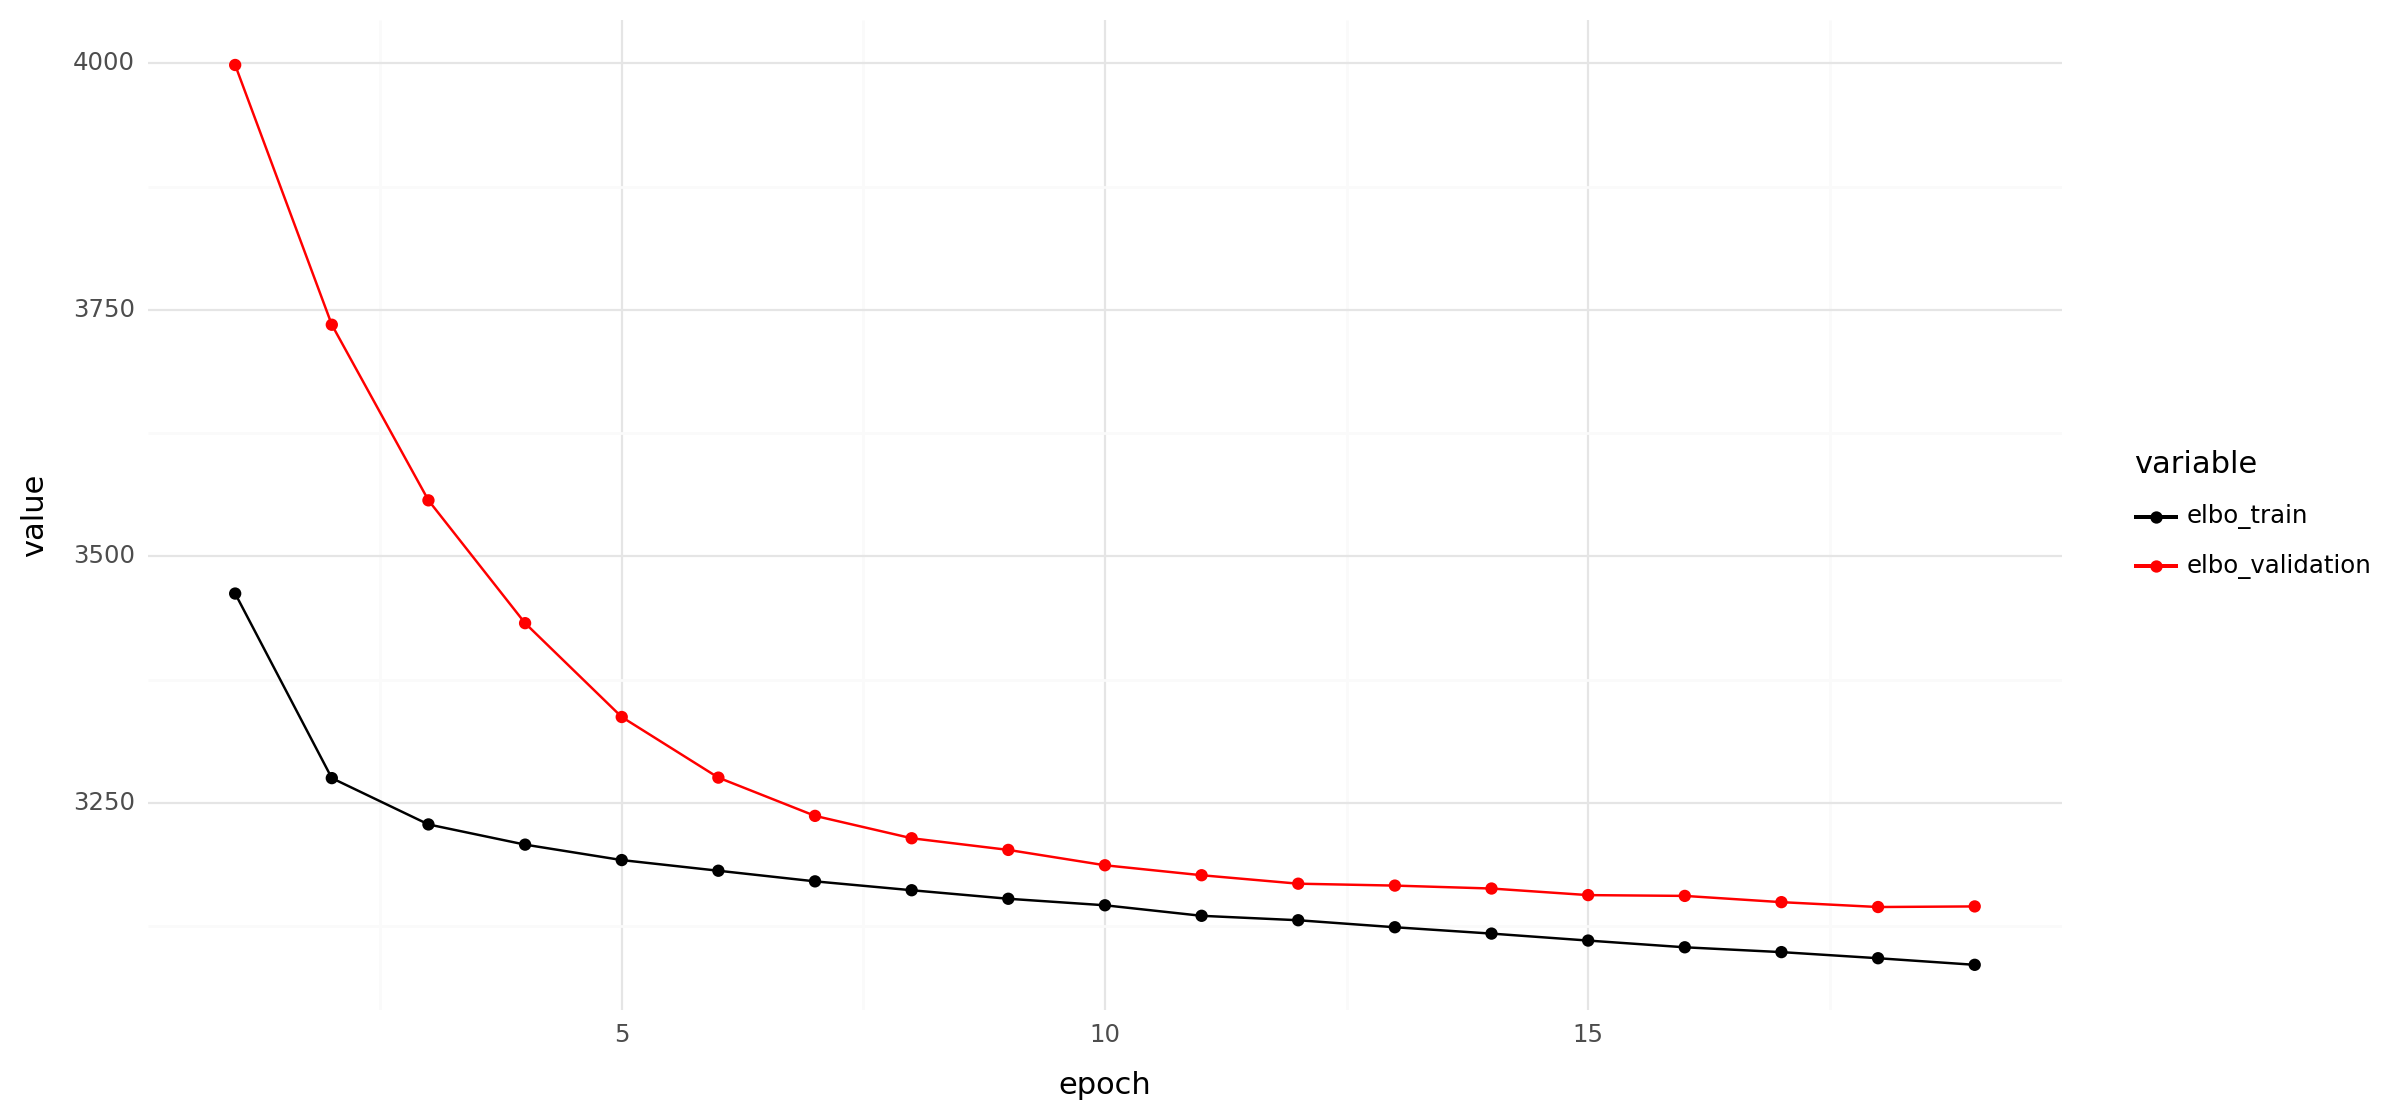

In [33]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [34]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [35]:
scanvi_model.train(30, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True, 
                   use_gpu = 0)

INFO     Training for 30 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 4/30:  10%|█         | 3/30 [00:01<00:10,  2.69it/s, v_num=1, train_loss_step=2.92e+3, train_loss_epoch=3.11e+3]

In [ ]:
adata.obs["C_scANVI_new"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

In [ ]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.6, spread = 6, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['genotype', 'cell_source', 'C_scANVI_new', 'sample', 'seed_labels'], size = 2, legend_fontsize = 5, ncols = 3)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts'], size = 1, legend_fontsize = 5, ncols = 4, cmap = 'magma')

### Modify object to plot canonical marker genes

In [ ]:
adata_toplot = anndata.AnnData(X = np.sqrt(sc.pp.normalize_total(adata_raw, inplace = False)["X"]), var = adata_raw.var, obs = adata.obs, obsm = adata.obsm)
adata_toplot

In [ ]:
sc.pl.umap(adata_toplot, frameon = False, color = ['C_scANVI_new', 'Ttn', 'Nppa', 'Dcn', 'Vwf', 'Myh11', 'Rgs4', 'Kcnj8', 'C1qa', 'Cd3e', 'Trem2', 'Adipoq', 'Nrxn1', 'Msln'], size = 1, legend_fontsize = 5, ncols = 4, cmap = 'RdPu')

### Visualise proportions

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['sample', 'genotype', 'C_scANVI_new'], size = 0.6, legend_fontsize = 5, ncols = 4)

In [ ]:
bauhaus_colors = ['#FF0000', '#FFFF00', '#000000', '#4D5D53', '#0000FF', '#808080']

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI_new'], size = 0.6, legend_fontsize = 5, ncols = 4, palette = bauhaus_colors)

In [ ]:
df = adata_toplot.obs.groupby(['genotype', 'C_scANVI_new']).size().reset_index(name = 'counts')

grouped = df.groupby('genotype')['counts'].apply(lambda x: x / x.sum() * 100)
grouped = grouped.reset_index()

df['proportions'] = grouped['counts']
df['waffle_counts'] = (df['proportions'] * 10).astype(int)

In [ ]:
def generate_modified_bauhaus_palette(n_colors):
    # Define specific shades
    base_colors = [
        (1, 0, 0),      # Red
        (0.07, 0.04, 0.56),  # Ultramarine blue
        (0, 0.28, 0.67),  # Cobalt blue
        (1, 0.9, 0),  # Bauhaus yellow
        (0, 0, 0),  # Black
        (0.5, 0, 0.5),  # Purple
        (1, 0.55, 0),  # Orange
        (0.54, 0.17, 0.89),  # Violet
    ]

    # Create more distinct variations of each base color
    colors = []
    variation_steps = n_colors // len(base_colors) + 1
    for color in base_colors:
        for i in range(variation_steps):
            # Adjusting brightness and saturation
            variation = tuple(min(max(c * (0.8 + i * 0.1), 0), 1) for c in color)
            colors.append(variation)

    # Ensure we only use the number of colors needed
    unique_colors = []
    for color in colors:
        if color not in unique_colors:
            unique_colors.append(color)
        if len(unique_colors) == n_colors:
            break

    # Shuffle the unique colors
    np.random.shuffle(unique_colors)

    return unique_colors

# Generate the modified palette
bauhaus_palette = generate_modified_bauhaus_palette(18)

In [ ]:
for group in df['genotype'].unique():
    temp_df = df[df['genotype'] == group]
    data = dict(zip(temp_df['C_scANVI_new'], temp_df['waffle_counts']))

    # Ensure the color list matches the number of cell types
    colors = [bauhaus_palette[i % len(bauhaus_palette)] for i in range(len(temp_df['C_scANVI_new']))]

    fig = plt.figure(
        FigureClass=Waffle, 
        rows=7, 
        values=data, 
        title={'label': f'Genotype {group}', 'loc': 'left', 'fontsize': 14},
        labels=[f"{k} ({v}%)" for k, v in zip(temp_df['C_scANVI_new'], temp_df['proportions'].round(2))],
        legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0, 'fontsize': 14},
        figsize=(40, 4),
        colors=colors
    )
    plt.show()

### Export annotated sample object 

In [ ]:
adata.obs.index = pd.Index(['-'.join(idx.split('-')[:2]) for idx in adata.obs.index])
adata.obs.index

In [ ]:
adata_raw.obs.index = pd.Index(['-'.join(idx.split('-')[:2]) for idx in adata_raw.obs.index])
adata_raw.obs.index

In [ ]:
adata.obs_names

In [ ]:
adata.obs['C_scANVI_new'].cat.categories

In [ ]:
adata.obs['C_scANVI_new'].value_counts()

### Export annotated object with raw counts

In [ ]:
adata

In [ ]:
adata_raw

In [ ]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)
adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export.obsm['X_scANVI'] = adata.obsm['X_scANVI'].copy()
adata_export.obsp = adata.obsp.copy()
adata_export.uns = adata.uns.copy()
adata_export